# Environment

In [1]:
import torchaudio
import numpy as np
from torch import Tensor
from IPython.display import Audio
from matplotlib import pyplot as plt
from helpers.path_utils import get_base_dir
from scipy.signal import decimate, find_peaks
from helpers.audio_utils import min_max_scale, trim_audio
from helpers.plot import plot_waveform_and_spectrograms, plot_audio_fft

# Load audio

Sample rate:  4000


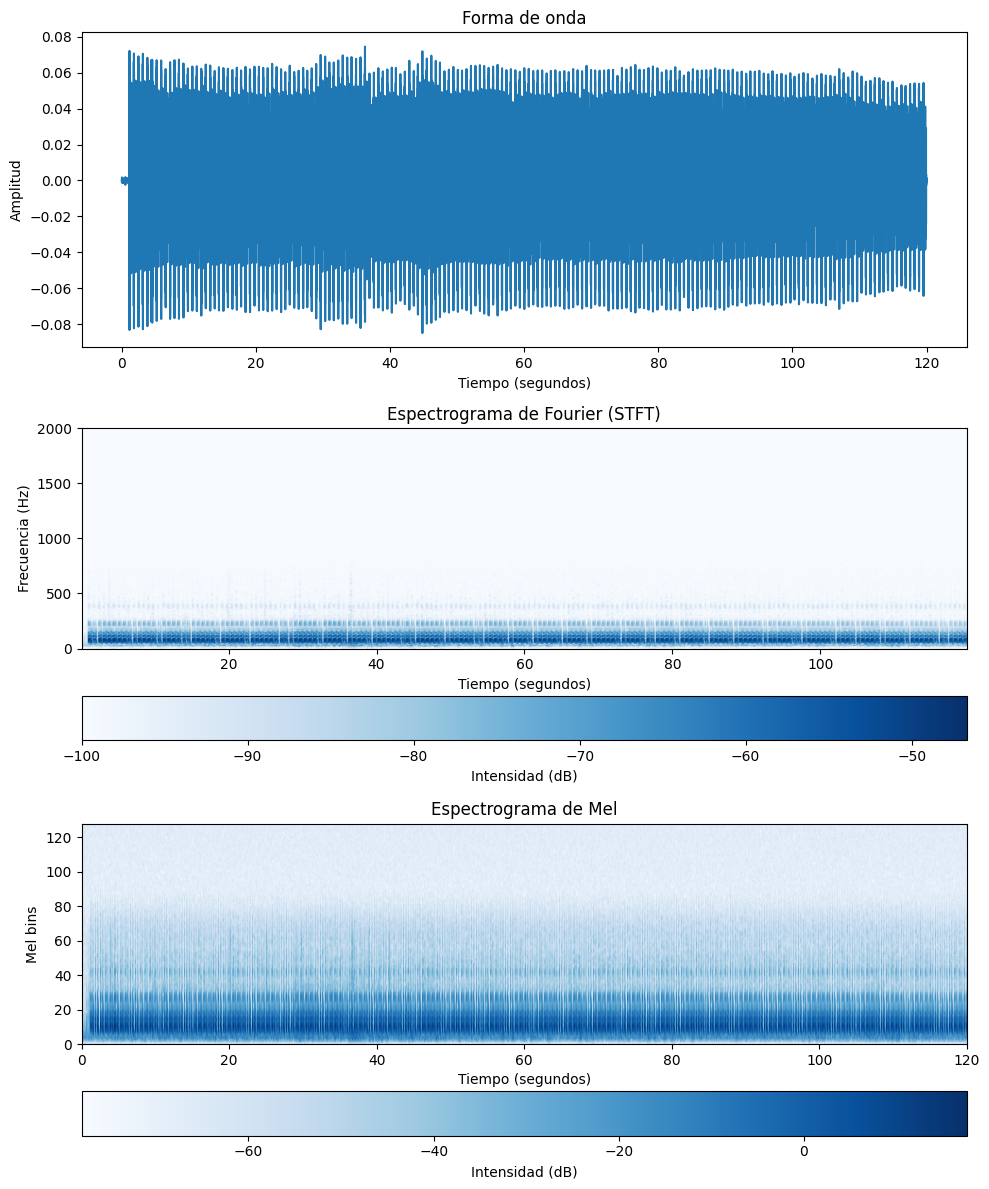

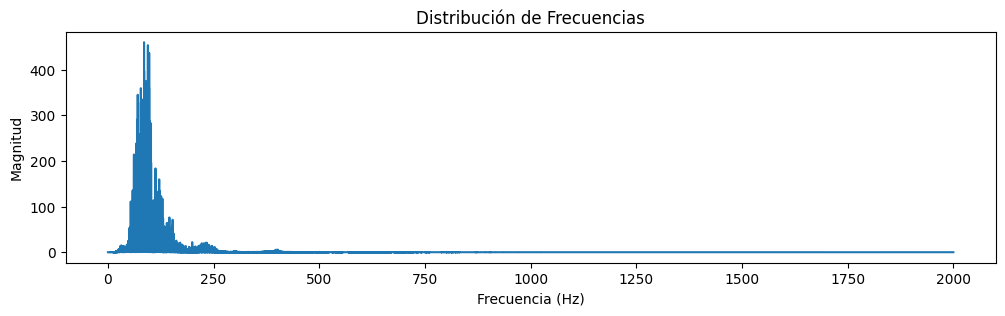

In [2]:
AUDIO_NAME = "SAM-Third Heart Sound.wav"
audio_dir = get_base_dir().joinpath("data", "stethos", "SAM", AUDIO_NAME)

audio, sample_rate = torchaudio.load(str(audio_dir))
print("Sample rate: ", sample_rate)

plot_waveform_and_spectrograms(audio, sample_rate)
plot_audio_fft(audio, sample_rate)

Audio(audio, rate=sample_rate, autoplay=True)

# Snippet to detect hearbeats

In [3]:
SNIPPET_STARTS = 0
SNIPPET_ENDS = 4

snippet = trim_audio(audio, sample_rate, SNIPPET_STARTS, SNIPPET_ENDS)
audio.shape, snippet.shape

(torch.Size([1, 480000]), torch.Size([1, 16000]))

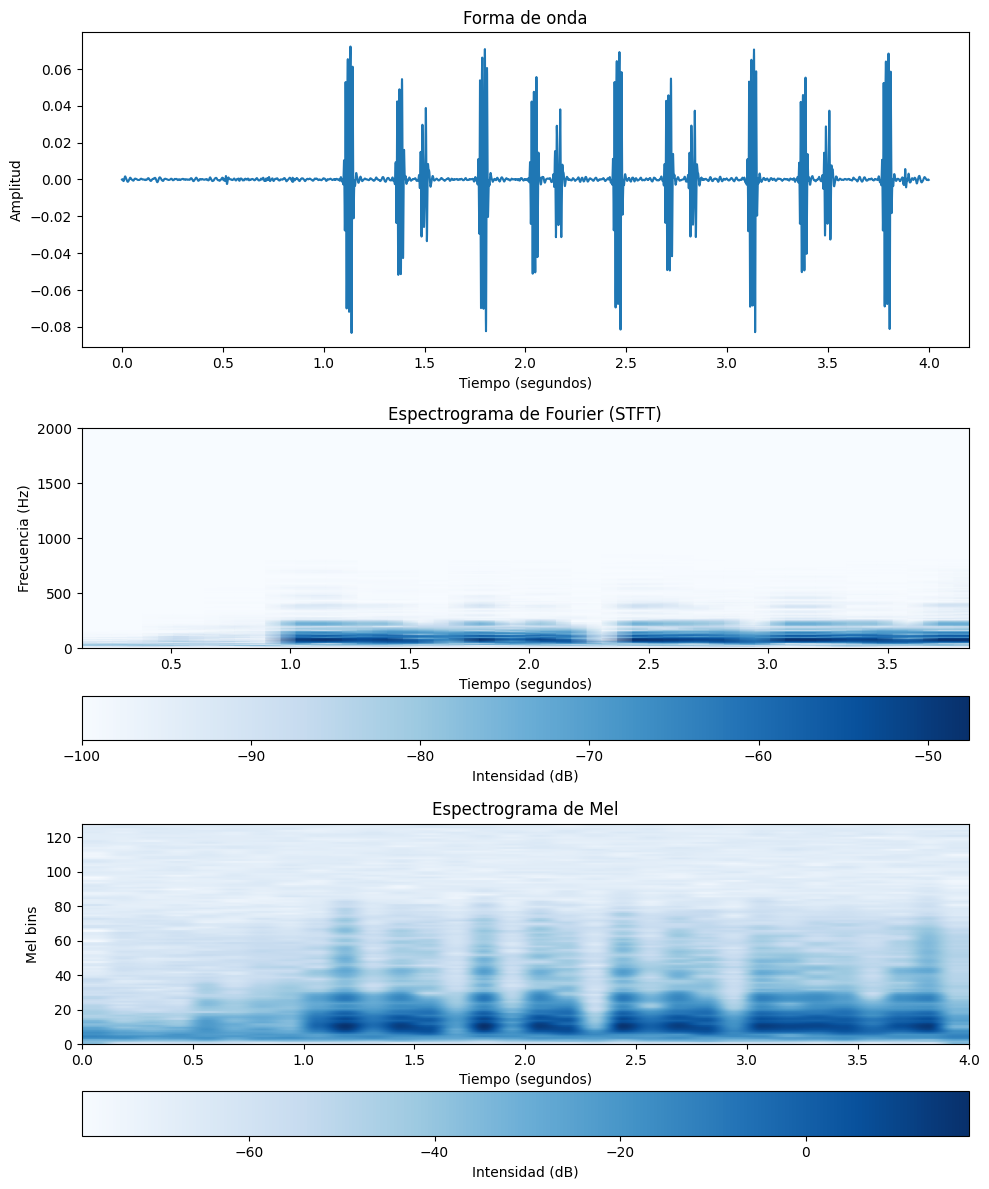

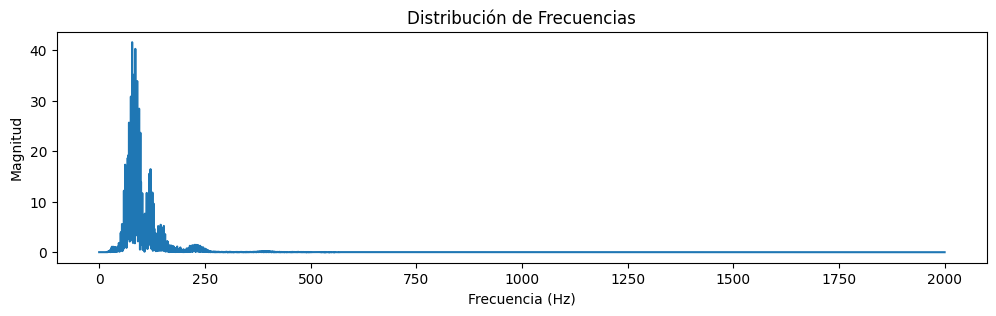

In [4]:
plot_waveform_and_spectrograms(snippet, sample_rate)
plot_audio_fft(snippet, sample_rate)

Audio(snippet, rate=sample_rate, autoplay=True)

# Transform signal to detect heartbeats

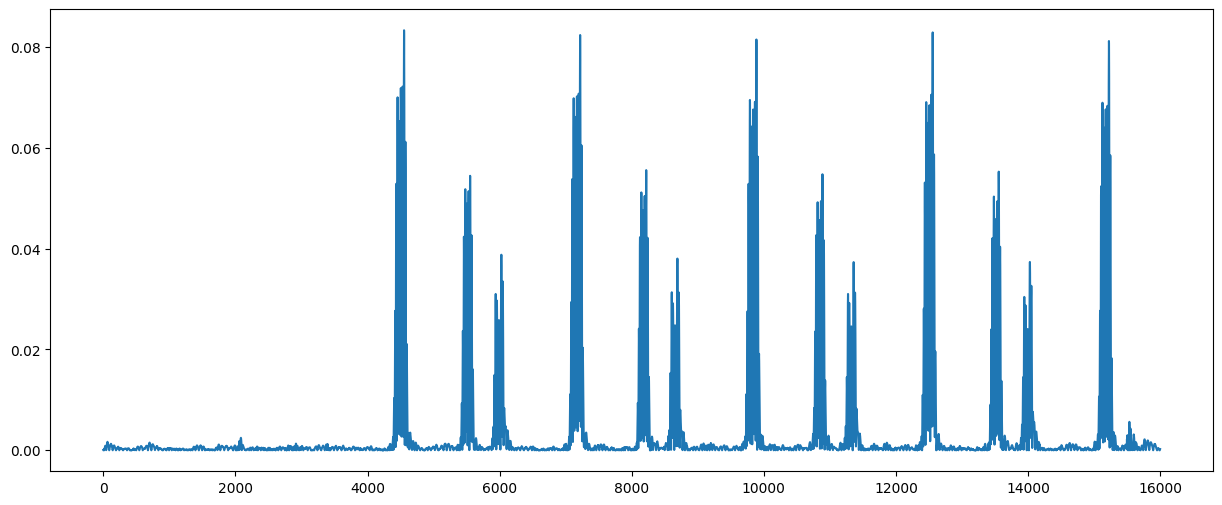

In [5]:
abs_snippet = snippet.abs()
plt.figure(figsize=(15, 6))
plt.plot(abs_snippet.squeeze())

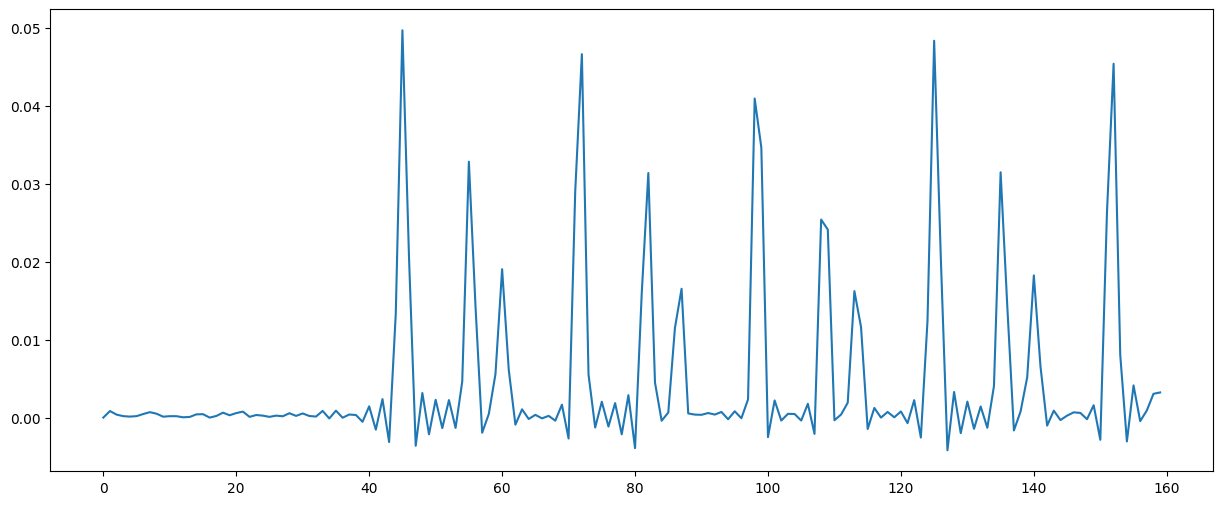

In [6]:
DOWNSAMPLE_FACTOR = 100
downsampled = decimate(abs_snippet, DOWNSAMPLE_FACTOR)

plt.figure(figsize=(15, 6))
plt.plot(downsampled.squeeze())

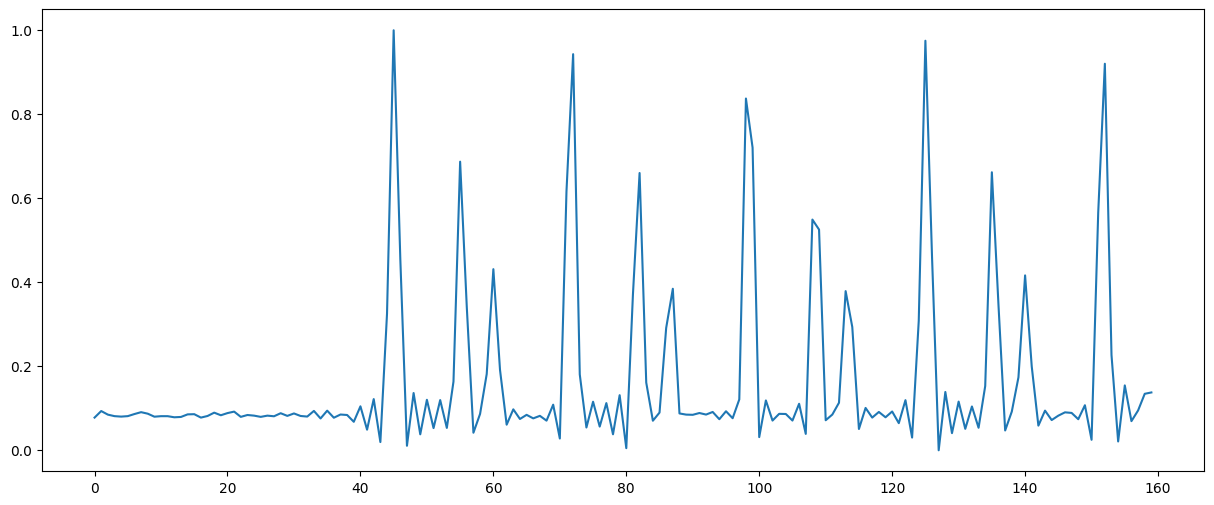

In [7]:
scaled = min_max_scale(Tensor(downsampled.copy())).squeeze()

plt.figure(figsize=(15, 6))
plt.plot(scaled.squeeze())

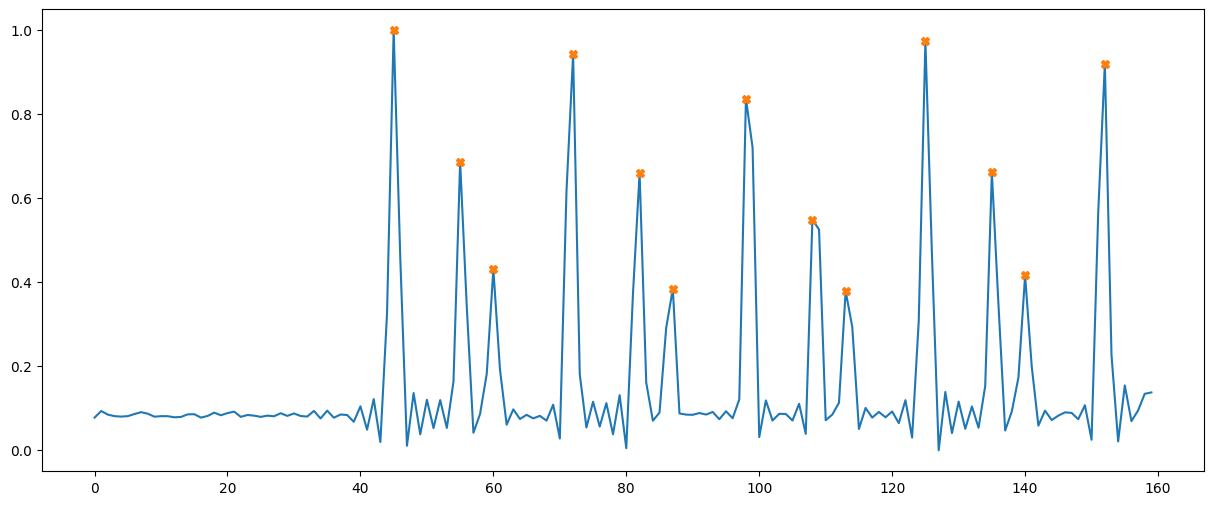

In [8]:
PEAKS_HEIGHT = np.percentile(scaled, 80)
PEAKS_PROMINENCE = 0.2

peaks, _ = find_peaks(scaled, height=PEAKS_HEIGHT, prominence=PEAKS_PROMINENCE)

plt.figure(figsize=(15, 6))
plt.plot(scaled)
plt.plot(peaks, scaled[peaks], "X")

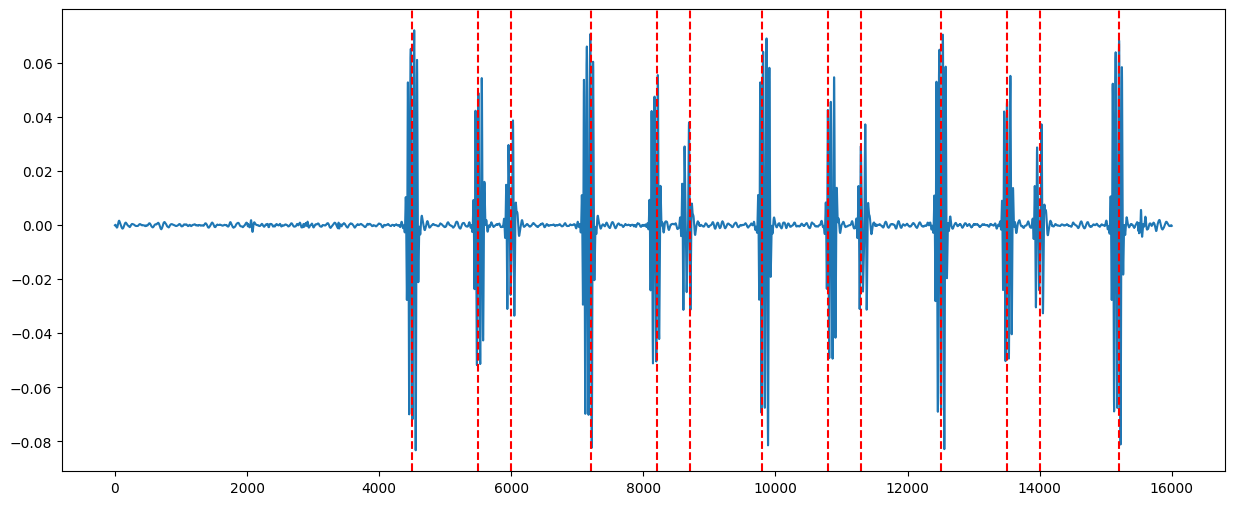

Peaks found in downsampled signal: [ 45  55  60  72  82  87  98 108 113 125 135 140 152]
Peaks in real signal: [ 4500  5500  6000  7200  8200  8700  9800 10800 11300 12500 13500 14000
 15200]
Difference between each: [1000  500 1200 1000  500 1100 1000  500 1200 1000  500 1200]


In [9]:
upsampled_peaks = peaks * DOWNSAMPLE_FACTOR

plt.figure(figsize=(15, 6))
plt.plot(snippet.squeeze())

for peak in upsampled_peaks:
    plt.axvline(x=peak, color="red", linestyle="--")

plt.show()

print(f"Peaks found in downsampled signal: {peaks}")
print(f"Peaks in real signal: {upsampled_peaks}")
print(f"Difference between each: {np.diff(upsampled_peaks)}")